In [ ]:
%matplotlib widget

import glob
from pathlib import Path

import arviz as az
import joblib
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, 
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_dic_data,
    get_image,
    get_multi_dic_data,
)
from ppcluster.mcmc import plot_1d_velocity_clustering
from ppcluster.preprocessing import apply_dic_filters, spatial_subsample, preproc_features
from ppcluster.roi import PolygonROISelector

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [18]:
camera_name = "PPCX_Tele"
reference_start_date = "2024-08-23"
reference_end_date = "2024-08-28"

SUBSAMPLE_FACTOR = 2  # Take every n point
SUBSAMPLE_METHOD = "regular"  # or 'random', 'stratified'
PRIOR_STRENGTH = 0.4  # Between 0 and 1

output_dir = Path("output") / f"{camera_name}_PyMC"
base_name = f"{camera_name}_{reference_start_date}_PyMC_GMM"
output_dir.mkdir(parents=True, exist_ok=True)

# Get DIC analysis metadata

# dic_ids = (629,)
# target_date = "2024-08-23"
# dic_ids = get_dic_analysis_ids(
#     db_engine, reference_date=target_date, camera_name=camera_name
# )
dic_ids = get_dic_analysis_ids(
    db_engine,
    camera_name=camera_name,
    reference_date_start=reference_start_date,
    reference_date_end=reference_end_date,
)

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=dic_ids)

# Get master image
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(master_image_id, camera_name=camera_name)

In [19]:
# Fetch DIC data
if len(dic_ids) == 0:
    raise ValueError("No DIC analyses found for the given criteria")
elif len(dic_ids) == 1:
    logger.info(f"Using DIC ID: {dic_ids[0]}")
    df = get_dic_data(dic_ids[0])
    df = apply_dic_filters(
        df,
        filter_outliers=config.get("dic.filter_outliers"),
        tails_percentile=config.get("dic.tails_percentile"),
        min_velocity=config.get("dic.min_velocity"),
        apply_2d_median=config.get("dic.apply_2d_median"),
        median_window_size=config.get("dic.median_window_size"),
        median_threshold_factor=config.get("dic.median_threshold_factor"),
    )
else:
    out = get_multi_dic_data(dic_ids, stack_results=False)
    # Apply filter for each df in the dictionary and then stack them
    logger.info(f"Found stack of {len(out)} DIC dataframes. Run filtering...")
    df = pd.concat(
        [
            apply_dic_filters(
                df,
                filter_outliers=config.get("dic.filter_outliers"),
                tails_percentile=config.get("dic.tails_percentile"),
                min_velocity=config.get("dic.min_velocity"),
                apply_2d_median=config.get("dic.apply_2d_median"),
                median_window_size=config.get("dic.median_window_size"),
                median_threshold_factor=config.get("dic.median_threshold_factor"),
            )
            for df in out.values()
        ],
        ignore_index=True,
    )

# To interactively select a ROI:
# selector = PolygonROISelector(file_path=config.get("data.roi_path"))
# selector.draw_interactive(image=img)

# Apply ROI filter
selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = selector.filter_dataframe(df, x_col="x", y_col="y")
logger.info(f"Data shape after filtering: {df.shape}")


# Apply subsampling AFTER ROI filtering
if SUBSAMPLE_FACTOR > 0:
    logger.info(f"Data shape before subsampling: {df.shape}")
    df_subsampled = spatial_subsample(
        df, n_subsample=SUBSAMPLE_FACTOR, method=SUBSAMPLE_METHOD
    )
    df = df_subsampled
    logger.info(f"Data shape after subsampling: {df.shape}")

# === FEATURE PREPARATION ===

# Get clustering parameters from config
variables_names = config.get("clustering.variables_names")
logger.info(f"Using features: {variables_names}")

# Preprocess features
df_features = preproc_features(df)
X = df_features[variables_names].values
n_features = X.shape[1]
ndata = X.shape[0]

# Standardize features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
logger.info(f"Feature matrix shape: {X_scaled.shape}")

2025-09-10 15:36:00 | [INFO    ] Found stack of 6 DIC dataframes. Run filtering...
2025-09-10 15:36:02 | [INFO    ] Data shape after filtering: (11233, 5)
2025-09-10 15:36:02 | [INFO    ] Data shape before subsampling: (11233, 5)
2025-09-10 15:36:02 | [INFO    ] Data shape after subsampling: (5617, 5)
2025-09-10 15:36:02 | [INFO    ] Using features: ['V']
2025-09-10 15:36:02 | [INFO    ] Feature matrix shape: (5617, 1)


Filtered 20994 points to 11233 points inside polygon
Subsampled from 11233 to 5617 points (50.0%)


In [20]:
# from sklearn.preprocessing import RobustScaler

# std_scaler = StandardScaler()
# std_scaler.fit(X)
# print(f"std scaler: {std_scaler.mean_}, {std_scaler.scale_}")


# r_scaler = RobustScaler()
# r_scaler.fit(X)
# print(f"robust scaler: {r_scaler.center_}, {r_scaler.scale_}")

2025-09-10 15:36:02 | [INFO    ] Found 4 sector polygons for priors
2025-09-10 15:36:02 | [INFO    ] Sector 0: 617 points with strong prior
2025-09-10 15:36:02 | [INFO    ] Sector 1: 1074 points with strong prior
2025-09-10 15:36:02 | [INFO    ] Sector 2: 1124 points with strong prior
2025-09-10 15:36:02 | [INFO    ] Sector 3: 2488 points with strong prior


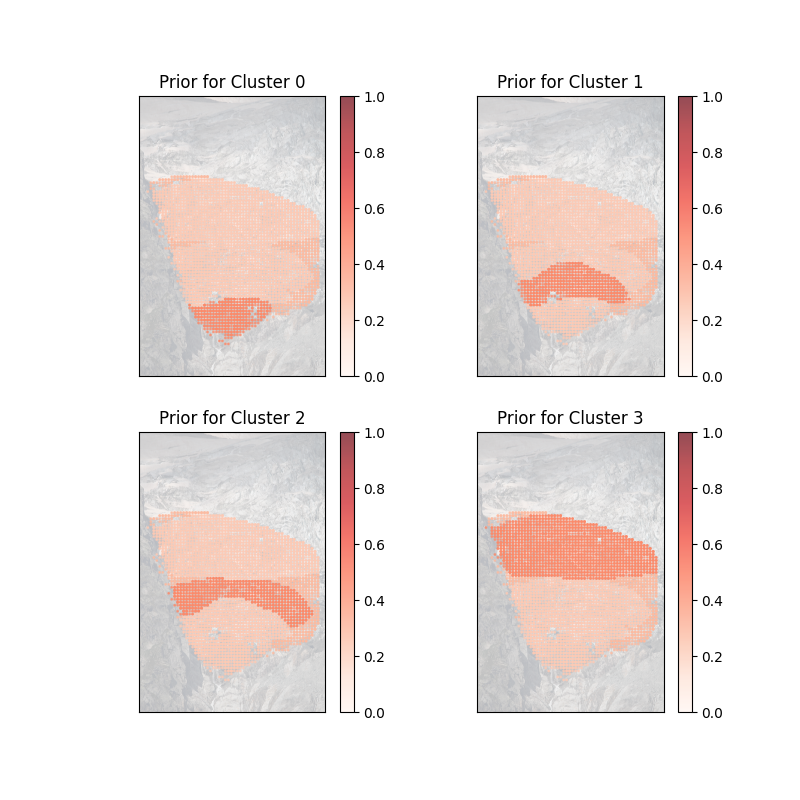

In [21]:
# === SPATIAL PRIOR SETUP ===
def assign_spatial_priors_dic(df, sectors, prior_strength=0.8):
    """Assign spatial prior probabilities based on polygon sectors."""
    ndata = len(df)
    k = len(sectors)
    prior_probs = np.ones((ndata, k)) / k  # default uniform

    for idx, sector in enumerate(sectors):
        mask = sector.contains_points(df["x"].values, df["y"].values)
        # Strong prior for points inside polygon
        prior_probs[mask] = (1 - prior_strength) / (
            k - 1
        )  # small prob for other clusters
        prior_probs[mask, idx] = prior_strength  # high prob for this cluster
        logger.info(f"Sector {idx}: {mask.sum()} points with strong prior")

    return prior_probs


# Load sector polygons for priors
sector_files = sorted(glob.glob(config.get("data.sector_prior_pattern")))
sector_sectors = [PolygonROISelector.from_file(f) for f in sector_files]
k = len(sector_sectors)  # number of clusters = number of sectors
logger.info(f"Found {k} sector polygons for priors")

# Assign priors
prior_probs = assign_spatial_priors_dic(
    df, sector_sectors, prior_strength=PRIOR_STRENGTH
)

# Visualize priors
nrows = int(np.ceil(np.sqrt(k)))
ncols = int(np.ceil(k / nrows))
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))
axes = [axes] if k == 1 else axes.flatten()
for cluster in range(k):
    axes[cluster].imshow(img, alpha=0.3)
    scatter = axes[cluster].scatter(
        df["x"],
        df["y"],
        c=prior_probs[:, cluster],
        cmap="Reds",
        s=1,
        alpha=0.7,
        vmin=0,
        vmax=1,
    )
    axes[cluster].set_title(f"Prior for Cluster {cluster}")
    axes[cluster].xaxis.set_ticks([])
    axes[cluster].yaxis.set_ticks([])
    plt.colorbar(scatter, ax=axes[cluster])

plt.show()

2025-09-10 15:36:06 | [INFO    ] Model with spatial priors created


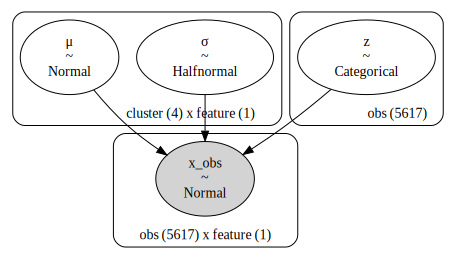

In [22]:
# === PYMC MODEL WITH SPATIAL PRIORS ===
with pm.Model(
    coords={"cluster": range(k), "feature": range(n_features), "obs": range(ndata)}
) as model:
    # Cluster means
    μ = pm.Normal("μ", mu=0, sigma=3, dims=("cluster", "feature"))

    # Cluster standard deviations (diagonal covariance)
    σ = pm.HalfNormal("σ", sigma=1.5, dims=("cluster", "feature"))

    # Cluster assignments with spatial priors
    z = pm.Categorical("z", p=prior_probs, dims="obs")

    # Likelihood: each point comes from its assigned cluster
    observations = pm.Normal(
        "x_obs", mu=μ[z], sigma=σ[z], observed=X_scaled, dims=("obs", "feature")
    )

logger.info("Model with spatial priors created")
pm.model_to_graphviz(model)

In [ ]:
# === SAMPLE FROM MODEL ===
with model:
    logger.info("Starting MCMC sampling...")
    idata = pm.sample(
        target_accept=0.9,
        draws=1000,
        tune=1000,
        chains=4,
        cores=4,
        random_seed=RANDOM_SEED,
    )

logger.info("Sampling completed!")

# --- SAVE OUTPUTS ---
# save the posterior InferenceData object
fpath = output_dir / f"{base_name}_pooled_posterior.idata.nc"
az.to_netcdf(idata, fpath)

# Save the scaler with joblib
joblib.dump(scaler, output_dir / f"{base_name}_scaler.joblib")


# Load the already sampled model
# idata = az.from_netcdf(output_dir / f"{base_name}_pooled_posterior.idata.nc")

2025-09-10 15:36:06 | [INFO    ] Starting MCMC sampling...
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [μ, σ]
>CategoricalGibbsMetropolis: [z]


Output()

In [ ]:
# Check R-hat (should be < 1.01)
print("R-hat values:")
rhat = az.rhat(idata)
print("\tmu values:", rhat.μ.values.flatten())
print("\tsigma values:", rhat.σ.values.flatten())

# Check effective sample size (should be > 100)
print("Effective sample size:")
ess = az.ess(idata)
print("\tmu values:", ess.μ.values.flatten())
print("\tsigma values:", ess.σ.values.flatten())


R-hat values:


/home/francesco/ppcx/ppcx-domains/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


	mu values: [1.03894323 1.01550702 1.03268152 1.00247676]
	sigma values: [1.0125428  1.01532176 1.02034742 1.00318224]
Effective sample size:
	mu values: [ 98.67965927 226.09383052  90.74343028 816.11324802]
	sigma values: [193.03087723 229.22865538 136.23539092 892.68481354]


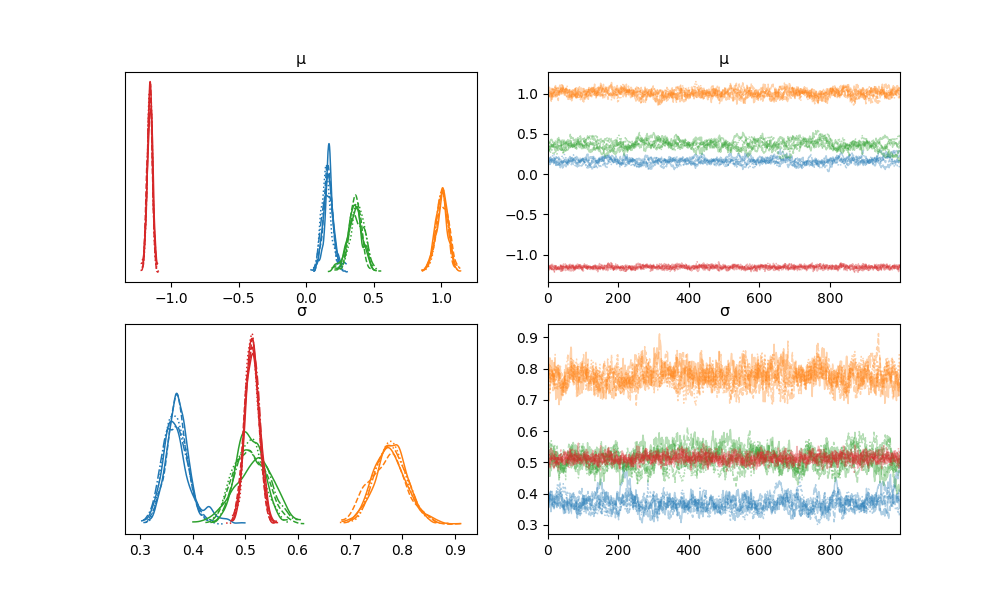

In [ ]:
# Plot trace plots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
az.plot_trace(idata, var_names=["μ", "σ"], axes=axes, compact=True)
fig.savefig(output_dir / f"{base_name}_trace_plot.png", dpi=150)

In [ ]:
# Get cluster assignments
z_posterior = idata.posterior["z"]
z_samples = z_posterior.values.reshape(-1, z_posterior.shape[-1])

cluster_pred = np.zeros(z_posterior.shape[-1], dtype=int)
for i in range(z_posterior.shape[-1]):
    values, counts = np.unique(z_samples[:, i], return_counts=True)
    cluster_pred[i] = values[np.argmax(counts)]

# Get model parameters
mu_posterior = idata.posterior["μ"].mean(dim=["chain", "draw"]).values.flatten()
sigma_posterior = idata.posterior["σ"].mean(dim=["chain", "draw"]).values.flatten()


In [ ]:
# For 1D velocity clustering
from matplotlib.colors import Normalize
from scipy.stats import norm as scipy_norm


def plot_1d_velocity_clustering(df_features, idata, img, scaler=None):
    """Specialized plot for 1D velocity-only clustering."""

    # Get cluster assignments
    z_posterior = idata.posterior["z"]
    z_samples = z_posterior.values.reshape(-1, z_posterior.shape[-1])

    cluster_pred = np.zeros(z_posterior.shape[-1], dtype=int)
    for i in range(z_posterior.shape[-1]):
        values, counts = np.unique(z_samples[:, i], return_counts=True)
        cluster_pred[i] = values[np.argmax(counts)]

    # Get model parameters
    mu_posterior = idata.posterior["μ"].mean(dim=["chain", "draw"]).values.flatten()
    sigma_posterior = idata.posterior["σ"].mean(dim=["chain", "draw"]).values.flatten()

    # Distinct colors
    unique_labels = np.unique(cluster_pred)
    colors = ["#E31A1C", "#1F78B4", "#33A02C", "#FF7F00", "#6A3D9A"][
        : len(unique_labels)
    ]
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    # Create figure with custom layout
    fig, axes = plt.subplots(2, 2, figsize=(8, 12))

    # Plot 1: Spatial clusters
    ax1 = axes[0, 0]
    ax1.set_title("Velocity-Based Spatial Clustering", fontsize=14, pad=10)

    if img is not None:
        ax1.imshow(img, alpha=0.3, cmap="gray")

    for label in unique_labels:
        mask = cluster_pred == label
        if np.any(mask):
            ax1.scatter(
                df_features.loc[mask, "x"],
                df_features.loc[mask, "y"],
                c=color_map[label],
                s=8,
                alpha=0.8,
                label=f"Velocity Cluster {label}",
                edgecolors="none",
            )
    ax1.legend(loc="upper right", framealpha=0.9, fontsize=10)
    ax1.set_aspect("equal")
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Plot 2: Velocity distribution
    ax3 = axes[0, 1]
    ax3.set_title("Velocity Distribution by Cluster", fontsize=14, pad=10)

    # Plot histograms for each cluster
    velocity = df_features["V"].values
    for label in unique_labels:
        mask = cluster_pred == label
        if np.any(mask):
            ax3.hist(
                velocity[mask],
                bins=35,
                alpha=0.7,
                density=True,
                color=color_map[label],
                label=f"Cluster {label}",
                edgecolor="white",
                linewidth=0.5,
            )

    # Overlay model distributions
    v_range = np.linspace(velocity.min(), velocity.max(), 200)
    for label in unique_labels:
        if scaler is not None:
            mu_orig = scaler.inverse_transform([[mu_posterior[label]]])[0, 0]
            sigma_orig = sigma_posterior[label] * scaler.scale_[0]
        else:
            mu_orig = mu_posterior[label]
            sigma_orig = sigma_posterior[label]

        model_dist = scipy_norm.pdf(v_range, mu_orig, sigma_orig)
        ax3.plot(
            v_range,
            model_dist,
            "--",
            color=color_map[label],
            linewidth=2.5,
            alpha=0.9,
            label=f"Model {label}",
        )
    ax3.set_xlabel("Velocity Magnitude", fontsize=12)
    ax3.set_ylabel("Density", fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=10, framealpha=0.9)

    # Plot 3: Velocity field with quiver plot
    ax2 = axes[1, 0]
    ax2.set_title("Velocity Vector Field", fontsize=14, pad=10)

    if img is not None:
        ax2.imshow(img, alpha=0.7, cmap="gray")

    # Create quiver plot
    magnitudes = df_features["V"].to_numpy()
    vmin = 0.0
    vmax = np.max(magnitudes)
    norm = Normalize(vmin=vmin, vmax=vmax)
    q = ax2.quiver(
        df_features["x"].to_numpy(),
        df_features["y"].to_numpy(),
        df_features["u"].to_numpy(),
        df_features["v"].to_numpy(),
        magnitudes,
        scale=None,
        scale_units="xy",
        angles="xy",
        cmap="viridis",
        norm=norm,
        width=0.003,
        headwidth=2.5,
        alpha=1.0,
    )

    # Add colorbar
    cbar = fig.colorbar(q, ax=ax2, shrink=0.8, aspect=20, pad=0.02)
    cbar.set_label("Velocity Magnitude", rotation=270, labelpad=15)
    ax2.set_aspect("equal")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.grid(False)

    # Plot 4: Statistics
    ax4 = axes[1, 1]
    ax4.axis("off")
    stats_text = "VELOCITY CLUSTERING STATISTICS\n" + "=" * 30 + "\n"
    for label in unique_labels:
        mask = cluster_pred == label
        count = mask.sum()

        if count == 0:
            continue

        v_mean = velocity[mask].mean()
        v_std = velocity[mask].std()
        v_median = np.median(velocity[mask])
        nmad = np.median(np.abs(velocity[mask] - v_median)) * 1.4826

        # Model parameters (in original scale)
        if scaler is not None:
            model_mu = scaler.inverse_transform([[mu_posterior[label]]])[0, 0]
            model_sigma = sigma_posterior[label] * scaler.scale_[0]
        else:
            model_mu = mu_posterior[label]
            model_sigma = sigma_posterior[label]

        stats_text += f"VELOCITY CLUSTER {label} (pts: {count})\n"
        stats_text += f"├─ Velocity: {v_mean:.4f} ± {v_std:.4f}\n"
        stats_text += f"├─ Median/NMAD: {v_median:.4f}/{nmad:.4f}\n"
        stats_text += f"├─ Model μ/σ: {model_mu:.4f}/{model_sigma:.4f}\n\n"

    ax4.text(
        0.05,
        0.95,
        stats_text,
        transform=ax4.transAxes,
        fontsize=8,
        verticalalignment="top",
        fontfamily="monospace",
        bbox=dict(
            boxstyle="round,pad=0.4", facecolor="lightblue", alpha=0.8, edgecolor="navy"
        ),
    )

    return cluster_pred, fig


cluster_pred_1d, fig_1d = plot_1d_velocity_clustering(df_features, idata, img, scaler)
fig_1d.savefig(
    output_dir / f"{base_name}_velocity_only_results.png", dpi=300, bbox_inches="tight"
)